Training Path: h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\data\mathematical_operations\training
Testing Path: h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\data\mathematical_operations\testing
Number of training files: 78
Number of testing files: 18
Processed file: division1.wav
Waveform shape: (48000,)


Spectrogram shape: (374, 129)


Audio playback:


Training Data Shape: (78, 374, 129)
Training Labels Shape: (78, 6)
Label Mapping: {'division': 0, 'multiplicacion': 1, 'potenciacion': 2, 'raizcuadrada': 3, 'resta': 4, 'suma': 5}
Testing Data Shape: (18, 374, 129)
Testing Labels Shape: (18, 6)
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - accuracy: 0.1424 - loss: 8.0585 - val_accuracy: 0.6111 - val_loss: 1.8796
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.4996 - loss: 1.8204 - val_accuracy: 0.4444 - val_loss: 1.4348
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step - accuracy: 0.7069 - loss: 1.1878 - val_accuracy: 0.7222 - val_loss: 1.3474
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.8713 - loss: 0.8420 - val_accuracy: 0.7222 - val_loss: 0.8298
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - accuracy: 0.9370 - loss: 0.2377 - val_accuracy: 0.7222 - val_loss: 1.0034
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 1.0000 - loss: 0.0684 - val_accuracy: 0.7778 - val_loss: 0.7377

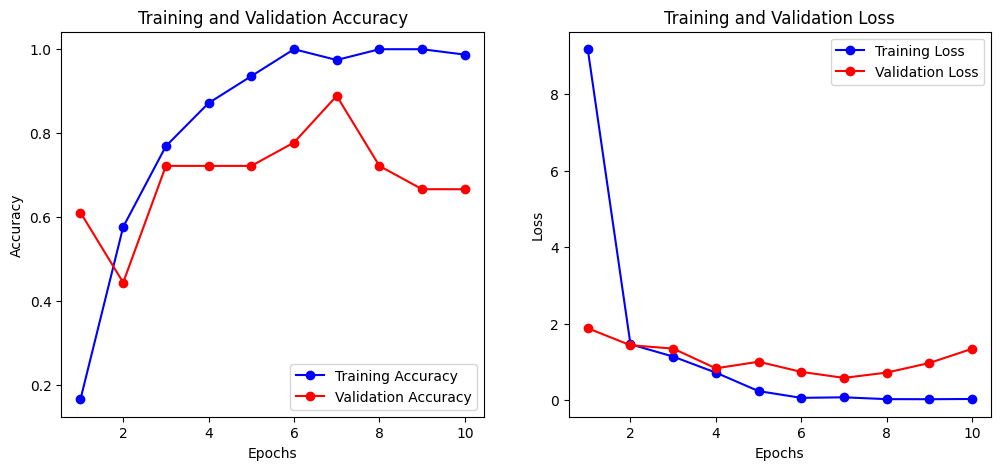

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


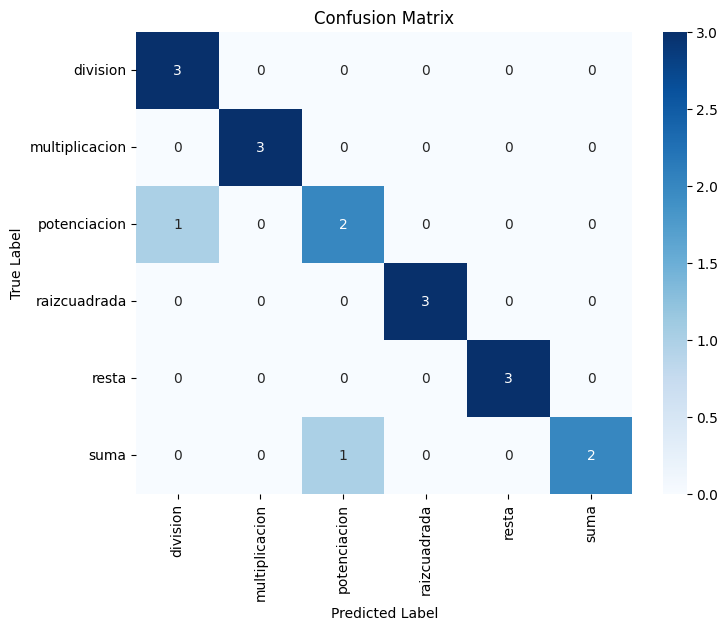

In [ ]:
# ============================
# Import Libraries
# ============================

import pathlib
import warnings
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.graph_objects import Figure, Scatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical
from IPython.display import Audio, display

# Suppress warnings
warnings.filterwarnings('always')

# ============================
# 1. Setup Paths and Validate
# ============================

# Define paths for training and testing data
base_dir = pathlib.Path.cwd().parent  # Adjust as needed
audios_dir = base_dir / "data" / "mathematical_operations"
training_path = audios_dir / "training"
testing_path = audios_dir / "testing"

# Validate the existence of directories
if not training_path.exists() or not testing_path.exists():
    raise FileNotFoundError("Training or testing directory not found.")

print(f"Training Path: {training_path}")
print(f"Testing Path: {testing_path}")

# ============================
# 2. Helper Functions
# ============================

def load_wav_16k_mono(filename):
    """Load a WAV file and resample to 16kHz mono."""
    file_contents = tf.io.read_file(filename)
    wav, _ = tf.audio.decode_wav(file_contents, desired_channels=1)
    return tf.squeeze(wav, axis=-1).numpy()

def preprocess_wave(wave, sample_rate=16000, duration_sec=3):
    """Truncate or pad waveform and compute the spectrogram."""
    target_length = sample_rate * duration_sec
    wave = wave[:target_length] if len(wave) > target_length else np.pad(wave, (0, target_length - len(wave)), 'constant')
    spectrogram = tf.signal.stft(wave, frame_length=255, frame_step=128)
    return tf.abs(spectrogram).numpy()

def plot_spectrogram(spectrogram, title, save_path=None):
    """Visualize a spectrogram using Plotly."""
    epsilon = 1e-10
    log_spec = np.log(spectrogram + epsilon).T
    fig = go.Figure(data=go.Heatmap(z=log_spec, colorscale='Viridis'))
    fig.update_layout(title=title, xaxis_title='Time Bins', yaxis_title='Frequency Bins')
    if save_path:
        fig.write_html(str(save_path / f"{title}.html"))
    fig.show()

def plot_3d_spectrogram(spectrogram, title='3D Spectrogram', save_path=None):
    """Plot a 3D spectrogram using Plotly."""
    spectrogram_np = spectrogram if isinstance(spectrogram, np.ndarray) else spectrogram.numpy()
    x, y = np.arange(spectrogram_np.shape[1]), np.arange(spectrogram_np.shape[0])
    X, Y = np.meshgrid(x, y)
    Z = np.abs(spectrogram_np)
    fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title='Time', yaxis_title='Frequency', zaxis_title='Magnitude'),
    )
    if save_path:
        fig.write_html(str(save_path / f"{title}.html"))
    fig.show()

# ============================
# 3. Process Training and Testing Files
# ============================

# List training and testing audio files
training_audio_list = list(training_path.glob("*.wav"))
testing_audio_list = list(testing_path.glob("*.wav"))

print(f"Number of training files: {len(training_audio_list)}")
print(f"Number of testing files: {len(testing_audio_list)}")

# Load and process a single training file
if training_audio_list:
    sample_file_path = str(training_audio_list[0])
    wave = load_wav_16k_mono(sample_file_path)
    print(f"Processed file: {training_audio_list[0].name}")
    print(f"Waveform shape: {wave.shape}")

# ============================
# 4. Visualize Waveform
# ============================

# Directory to save visualizations
image_output_path = base_dir / "images"
image_output_path.mkdir(parents=True, exist_ok=True)

# Plot waveform
fig_wave = Figure()
x_samples = np.arange(len(wave))
fig_wave.add_trace(Scatter(x=x_samples, y=wave, mode='lines', name='Waveform'))
fig_wave.update_layout(title="Training Audio 1", xaxis_title="Samples", yaxis_title="Amplitude")
fig_wave.show()
fig_wave.write_html(str(image_output_path / "Training_Audio_1_Waveform.html"))

# ============================
# 5. Generate and Visualize Spectrogram
# ============================

spectrogram = preprocess_wave(wave)
print(f"Spectrogram shape: {spectrogram.shape}")

plot_spectrogram(spectrogram, "Training Audio 1 - Spectrogram", save_path=image_output_path)
plot_3d_spectrogram(spectrogram, "Training Audio 1 - 3D Spectrogram", save_path=image_output_path)

# ============================
# 6. Audio Playback for Verification
# ============================

print("Audio playback:")
display(Audio(wave, rate=16000))

# ============================
# 7. Data Preparation for Model Training and Testing
# ============================

def prepare_data(audio_list, label_mapping=None, sample_rate=16000, duration_sec=3):
    """
    Prepare spectrograms and one-hot encoded labels from audio files.
    
    Args:
    - audio_list (list): List of audio file paths.
    - label_mapping (dict): Predefined mapping of labels to integers (optional).
    - sample_rate (int): Sample rate for audio processing.
    - duration_sec (int): Duration in seconds to standardize audio length.
    
    Returns:
    - X (np.array): Array of spectrograms.
    - y_onehot (np.array): One-hot encoded labels.
    - label_map (dict): Mapping of labels to integers (if not provided).
    """
    spectrograms = []
    labels = []

    for audio_file in audio_list:
        try:
            # Load and preprocess the audio file
            wave = load_wav_16k_mono(str(audio_file))
            spectrogram = preprocess_wave(wave, sample_rate, duration_sec)
            
            # Extract the label from the filename
            label = ''.join([char for char in audio_file.stem if not char.isdigit()])
            spectrograms.append(spectrogram)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {audio_file.name}: {e}")

    # If label mapping is not provided, create one
    if label_mapping is None:
        label_set = sorted(set(labels))  # Ensure consistent label order
        label_map = {label: idx for idx, label in enumerate(label_set)}
    else:
        label_map = label_mapping

    # Convert labels to integer indices
    y = np.array([label_map[label] for label in labels])

    # One-hot encode the labels
    y_onehot = keras.utils.to_categorical(y, num_classes=len(label_map))

    return np.array(spectrograms), y_onehot, label_map

# ============================
# Process Training Data
# ============================
X_train, y_train, label_mapping = prepare_data(training_audio_list)

print(f"Training Data Shape: {X_train.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Label Mapping: {label_mapping}")

# ============================
# Process Testing Data
# ============================
X_test, y_test, _ = prepare_data(testing_audio_list, label_mapping=label_mapping)

print(f"Testing Data Shape: {X_test.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

# ============================
# 8. Model Creation and Training
# ============================

# Function to create a CNN model
def create_model(input_shape, num_classes, dropout_rate=0.5):
    """
    Create and compile a CNN model with optional dropout.
    
    Args:
    - input_shape (tuple): Shape of the input data (height, width, channels).
    - num_classes (int): Number of output classes.
    - dropout_rate (float): Dropout rate to reduce overfitting.
    
    Returns:
    - model (keras.Sequential): Compiled CNN model.
    """
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = create_model(input_shape=X_train.shape[1:] + (1,), num_classes=len(label_mapping))

# Early Stopping to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train[..., np.newaxis], y_train,  # Add channel dimension
    validation_data=(X_test[..., np.newaxis], y_test),
    epochs=20,  # Increased epochs to allow Early Stopping
    batch_size=16,  # Adjust batch size based on memory
    callbacks=[early_stopping],
    verbose=1
)

# ============================
# 9. Training Visualization
# ============================

# Plot training and validation accuracy and loss
def plot_training_history(history):
    """
    Plot the training history of a model.
    
    Args:
    - history (keras.callbacks.History): Training history object.
    
    Returns:
    None
    """
    # Extract accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Visualize training history
plot_training_history(history)

# ============================
# 10. Testing and Confusion Matrix
# ============================

# Prepare testing data
X_test, y_test, _ = prepare_data(testing_audio_list, label_mapping=label_mapping)  # Already in indices
y_test_indices = np.argmax(y_test, axis=1)  # Convert one-hot encoding to indices

# Predict on testing data
y_pred_probs = model.predict(X_test[..., np.newaxis])  # Add channel dimension
y_pred_indices = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test_indices, y_pred_indices)

# Plot confusion matrix
def plot_confusion_matrix(confusion_mtx, class_names):
    """
    Plot a confusion matrix using seaborn.

    Args:
    - confusion_mtx (numpy.ndarray): Confusion matrix.
    - class_names (list): List of class names corresponding to matrix indices.

    Returns:
    None
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, list(label_mapping.keys()))


Training Path: h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\data\mathematical_operations\training
Testing Path: h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\data\mathematical_operations\testing
Training Data Shape: (78, 374, 129)
Training Labels Shape: (78, 6)
Label Mapping: {'division': 0, 'multiplicacion': 1, 'potenciacion': 2, 'raizcuadrada': 3, 'resta': 4, 'suma': 5}
Testing Data Shape: (18, 374, 129)
Testing Labels Shape: (18, 6)
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.1369 - loss: 6.4270 - val_accuracy: 0.3889 - val_loss: 2.3150
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.7037 - loss: 1.1570 - val_accuracy: 0.4444 - val_loss: 1.3490
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.9067 - loss: 0.6663 - val_accuracy: 0.6111 - val_loss: 0.9807

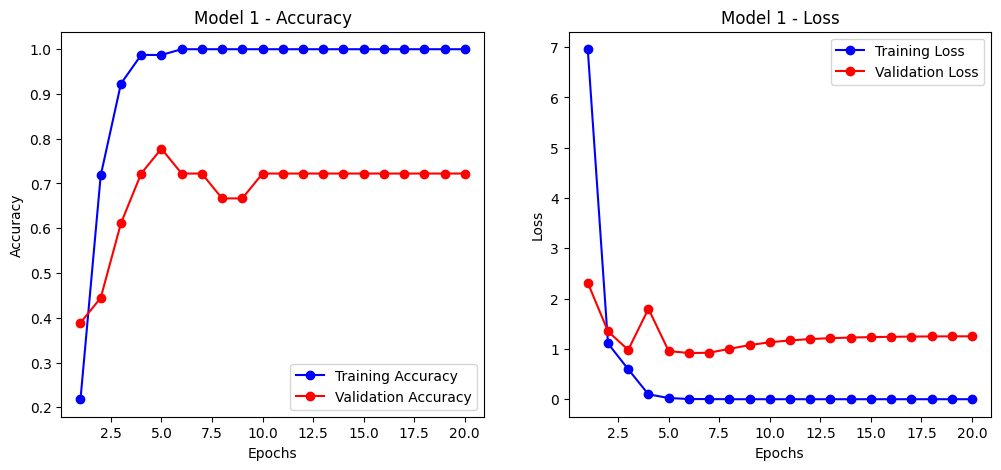

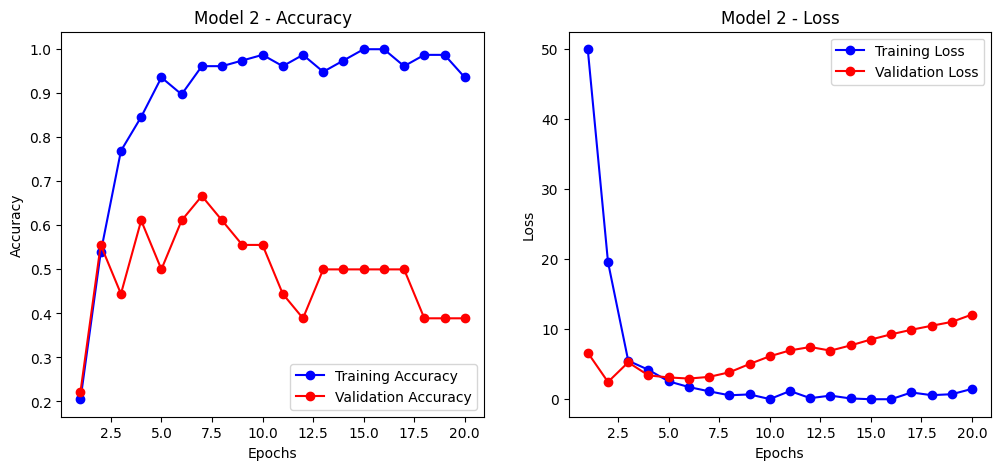

Evaluating Model 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


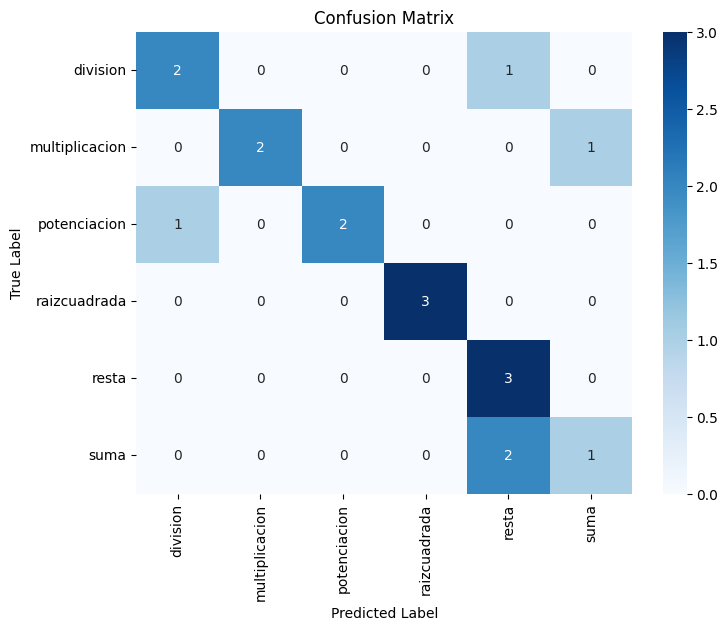

Classification Report:
                precision    recall  f1-score   support

      division       0.67      0.67      0.67         3
multiplicacion       1.00      0.67      0.80         3
  potenciacion       1.00      0.67      0.80         3
  raizcuadrada       1.00      1.00      1.00         3
         resta       0.50      1.00      0.67         3
          suma       0.50      0.33      0.40         3

      accuracy                           0.72        18
     macro avg       0.78      0.72      0.72        18
  weighted avg       0.78      0.72      0.72        18

Evaluating Model 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


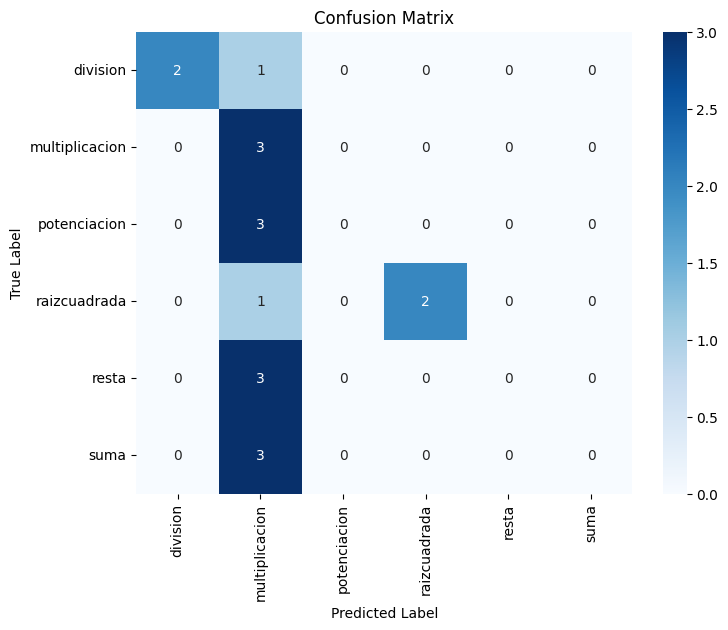

Classification Report:
                precision    recall  f1-score   support

      division       1.00      0.67      0.80         3
multiplicacion       0.21      1.00      0.35         3
  potenciacion       0.00      0.00      0.00         3
  raizcuadrada       1.00      0.67      0.80         3
         resta       0.00      0.00      0.00         3
          suma       0.00      0.00      0.00         3

      accuracy                           0.39        18
     macro avg       0.37      0.39      0.33        18
  weighted avg       0.37      0.39      0.33        18



In [27]:
# ============================
# Import Libraries
# ============================

import pathlib
import warnings
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from IPython.display import Audio, display

# Suppress warnings
warnings.filterwarnings('always')

# ============================
# 1. Setup Paths and Validate
# ============================

# Define paths for training, validation, and testing data
base_dir = pathlib.Path.cwd().parent
audios_dir = base_dir / "data" / "mathematical_operations"
training_path = audios_dir / "training"
# validation_path = audios_dir / "validation"
testing_path = audios_dir / "testing"

# Validate the existence of directories
if not training_path.exists() or not testing_path.exists():
    raise FileNotFoundError("Training, validation, or testing directory not found.")

print(f"Training Path: {training_path}")
# print(f"Validation Path: {validation_path}")
print(f"Testing Path: {testing_path}")

# ============================
# 2. Helper Functions
# ============================

def load_wav_16k_mono(filename):
    """Load a WAV file and resample to 16kHz mono."""
    file_contents = tf.io.read_file(filename)
    wav, _ = tf.audio.decode_wav(file_contents, desired_channels=1)
    return tf.squeeze(wav, axis=-1).numpy()

def preprocess_wave(wave, sample_rate=16000, duration_sec=3):
    """Truncate or pad waveform and compute the spectrogram."""
    target_length = sample_rate * duration_sec
    wave = wave[:target_length] if len(wave) > target_length else np.pad(wave, (0, target_length - len(wave)), 'constant')
    spectrogram = tf.signal.stft(wave, frame_length=255, frame_step=128)
    return tf.abs(spectrogram).numpy()

def prepare_data(audio_list, label_mapping=None, sample_rate=16000, duration_sec=3):
    """Prepare spectrograms and one-hot encoded labels from audio files."""
    spectrograms, labels = [], []
    for audio_file in audio_list:
        try:
            wave = load_wav_16k_mono(str(audio_file))
            spectrogram = preprocess_wave(wave, sample_rate, duration_sec)
            label = ''.join([char for char in audio_file.stem if not char.isdigit()])
            spectrograms.append(spectrogram)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {audio_file.name}: {e}")

    if label_mapping is None:
        label_set = sorted(set(labels))
        label_map = {label: idx for idx, label in enumerate(label_set)}
    else:
        label_map = label_mapping

    y = np.array([label_map[label] for label in labels])
    y_onehot = tf.keras.utils.to_categorical(y, num_classes=len(label_map))

    return np.array(spectrograms), y_onehot, label_map

# ============================
# 3. Load and Process Data
# ============================

# Process training data
training_audio_list = list(training_path.glob("*.wav"))
X_train, y_train, label_mapping = prepare_data(training_audio_list)
print(f"Training Data Shape: {X_train.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Label Mapping: {label_mapping}")

# # Process validation data
# validation_audio_list = list(validation_path.glob("*.wav"))
# X_test, y_test, _ = prepare_data(validation_audio_list, label_mapping=label_mapping)
# print(f"Validation Data Shape: {X_test.shape}")
# print(f"Validation Labels Shape: {y_test.shape}")

# Process testing data
testing_audio_list = list(testing_path.glob("*.wav"))
X_test, y_test, _ = prepare_data(testing_audio_list, label_mapping=label_mapping)
print(f"Testing Data Shape: {X_test.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

# ============================
# 4. Model Creation
# ============================

def create_model_1(input_shape, num_classes):
    """Create and compile the first CNN model."""
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model_2(input_shape, num_classes):
    """Create and compile the second CNN model with BatchNormalization and Dropout."""
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ============================
# 5. Train Models
# ============================

# Model 1
model_1 = create_model_1(input_shape=X_train.shape[1:] + (1,), num_classes=len(label_mapping))
history_1 = model_1.fit(
    X_train[..., np.newaxis], y_train,
    validation_data=(X_test[..., np.newaxis], y_test),
    epochs=20, batch_size=16,
    verbose=1
)

# Model 2
model_2 = create_model_2(input_shape=X_train.shape[1:] + (1,), num_classes=len(label_mapping))
history_2 = model_2.fit(
    X_train[..., np.newaxis], y_train,
    validation_data=(X_test[..., np.newaxis], y_test),
    epochs=20, batch_size=16,
    verbose=1
)

# ============================
# 6. Training Visualization
# ============================

def plot_training_history(history, model_name):
    """Plot training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Visualize Model 1
plot_training_history(history_1, "Model 1")

# Visualize Model 2
plot_training_history(history_2, "Model 2")

# # ============================
# # 7. Model Evaluation
# # ============================

# def evaluate_model(model, X_test, y_test, label_mapping):
#     """Evaluate the model on testing data and plot confusion matrix."""
#     y_test_indices = np.argmax(y_test, axis=1)
#     y_pred_probs = model.predict(X_test[..., np.newaxis])
#     y_pred_indices = np.argmax(y_pred_probs, axis=1)

#     confusion_mtx = confusion_matrix(y_test_indices, y_pred_indices)

#     plt.figure(figsize=(8, 6))
#     sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=list(label_mapping.keys()),
#                 yticklabels=list(label_mapping.keys()))
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()

# # Evaluate Model 1
# evaluate_model(model_1, X_test, y_test, label_mapping)

# # Evaluate Model 2
# evaluate_model(model_2, X_test, y_test, label_mapping)

# ============================
# 7. Model Evaluation
# ============================

def evaluate_model(model, X_test, y_test, label_mapping):
    """Evaluate the model on testing data and plot confusion matrix."""
    y_test_indices = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test[..., np.newaxis])
    y_pred_indices = np.argmax(y_pred_probs, axis=1)

    # Compute confusion matrix
    confusion_mtx = confusion_matrix(y_test_indices, y_pred_indices)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(label_mapping.keys()),
                yticklabels=list(label_mapping.keys()))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Generate classification report
    report = classification_report(
        y_test_indices,
        y_pred_indices,
        target_names=list(label_mapping.keys()),
        zero_division=0
        )
    print("Classification Report:")
    print(report)

# Evaluate Model 1
print("Evaluating Model 1:")
evaluate_model(model_1, X_test, y_test, label_mapping)

# Evaluate Model 2
print("Evaluating Model 2:")
evaluate_model(model_2, X_test, y_test, label_mapping)
